In [78]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt


In [79]:
airline_tweets=pd.read_csv("/content/drive/MyDrive/Data Sets/Tweets.csv")

In [80]:
airline_tweets.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [81]:
airline_tweets.shape

(14640, 15)

In [82]:
airline_tweets.airline_sentiment.value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

### EDA

<Axes: ylabel='count'>

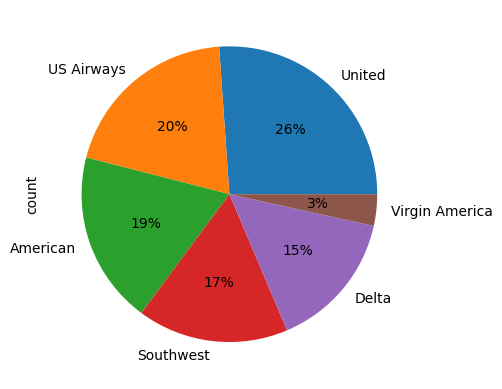

In [83]:
airline_tweets.airline.value_counts().plot(kind='pie',autopct='%1.0f%%')

<Axes: ylabel='count'>

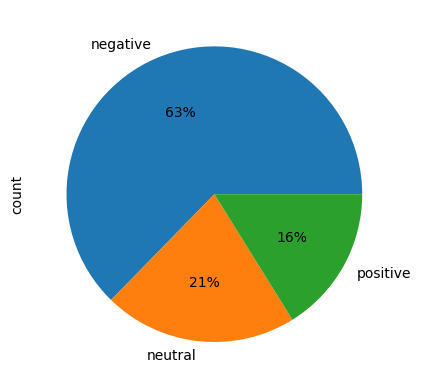

In [84]:
airline_tweets.airline_sentiment.value_counts().plot(kind='pie',autopct='%1.0f%%')

<Axes: xlabel='airline'>

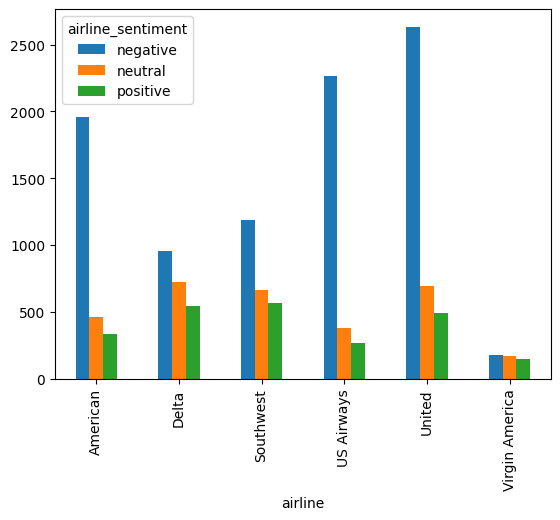

In [85]:
airline_sentiment =airline_tweets.groupby(['airline','airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

In [86]:
#Counting the all negative resons

airline_tweets.negativereason.value_counts()

negativereason
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: count, dtype: int64

In [87]:
air_senti=pd.crosstab(airline_tweets.airline,airline_tweets.airline_sentiment)
air_senti

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


In [88]:
percent=air_senti.apply(lambda a:a/a.sum()*100,axis=1)
percent

airline_sentiment,negative,neutral,positive
airline,,,
American,71.040232,16.781443,12.178325
Delta,42.979298,32.538254,24.482448
Southwest,49.008264,27.438017,23.553719
US Airways,77.686234,13.079300,9.234466
United,68.890633,18.236525,12.872841
Virgin America,35.912698,33.928571,30.158730


### Data Cleaning

In [89]:
features=airline_tweets.iloc[:,10].values
labels=airline_tweets.iloc[:,1].values

In [90]:
features

array(['@VirginAmerica What @dhepburn said.',
       "@VirginAmerica plus you've added commercials to the experience... tacky.",
       "@VirginAmerica I didn't today... Must mean I need to take another trip!",
       ...,
       '@AmericanAir Please bring American Airlines to #BlackBerry10',
       "@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",
       '@AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?'],
      dtype=object)

In [91]:
labels

array(['neutral', 'positive', 'neutral', ..., 'neutral', 'negative',
       'neutral'], dtype=object)

In [92]:
processed_features=[]

for sentence in range(0,len(features)):
  #Remove all special characters
  processed_feature=re.sub(r'\W',' ',str(features[sentence]))

  #Remove all single characters
  processed_feature=re.sub(r'\s+[a-zA-Z]\s+',' ',processed_feature)

  #Remove single character from the start
  processed_feature=re.sub(r'\^[a-zA-Z]\s+',' ',processed_feature)

  #Substituting multiple space with single space
  processed_feature=re.sub(r'\s+',' ',processed_feature,flags=re.I)

  #Removing prefixed 'b'
  processed_feature=re.sub(r'^b\s+',' ',processed_feature)

  #Converting into lowercase
  processed_feature=processed_feature.lower()

  processed_features.append(processed_feature)

In [93]:
processed_features

[' virginamerica what dhepburn said ',
 ' virginamerica plus you ve added commercials to the experience tacky ',
 ' virginamerica didn today must mean need to take another trip ',
 ' virginamerica it really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse',
 ' virginamerica and it a really big bad thing about it',
 ' virginamerica seriously would pay 30 flight for seats that didn have this playing it really the only bad thing about flying va',
 ' virginamerica yes nearly every time fly vx this ear worm won go away ',
 ' virginamerica really missed prime opportunity for men without hats parody there https co mwpg7grezp',
 ' virginamerica well didn but now do d',
 ' virginamerica it was amazing and arrived an hour early you re too good to me ',
 ' virginamerica did you know that suicide is the second leading cause of death among teens 10 24',
 ' virginamerica lt 3 pretty graphics so much better than minimal iconography d',
 ' virginamerica th

# **Representing Text in Numeric**

**TF-IDF**

In [94]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer=TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features=vectorizer.fit_transform(processed_features).toarray()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [95]:
processed_features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Train Test Split

In [108]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest=train_test_split(processed_features,labels,test_size=0.2,random_state=0)

### **Traning Model**

Random Forest

In [97]:
from sklearn.ensemble import RandomForestClassifier

text_classifier=RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(Xtrain,ytrain)

RandomForestClassifier(n_estimators=200, random_state=0)

In [98]:
ypred_random=text_classifier.predict(Xtest)

In [99]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

In [100]:
print('Confusion Matrix\n', confusion_matrix(ytest,ypred_random))
print('Classification report\n',classification_report(ytest,ypred_random))
print('Accuracy\n',accuracy_score(ytest,ypred_random))


Confusion Matrix
 [[1723  108   39]
 [ 326  248   40]
 [ 132   58  254]]
Classification report
               precision    recall  f1-score   support

    negative       0.79      0.92      0.85      1870
     neutral       0.60      0.40      0.48       614
    positive       0.76      0.57      0.65       444

    accuracy                           0.76      2928
   macro avg       0.72      0.63      0.66      2928
weighted avg       0.75      0.76      0.74      2928

Accuracy
 0.7599043715846995


KNN

In [101]:
from sklearn.neighbors import KNeighborsClassifier

knclassifier=KNeighborsClassifier(n_neighbors=5)
knclassifier.fit(Xtrain,ytrain)

KNeighborsClassifier()

In [102]:
ypred_knn=knclassifier.predict(Xtest)

In [103]:
print('Confusion Matrix\n',confusion_matrix(ytest,ypred_knn))
print('Classification Report\n',classification_report(ytest,ypred_knn))
print('Accuracy\n',accuracy_score(ytest,ypred_knn))

Confusion Matrix
 [[1506  310   54]
 [ 253  309   52]
 [ 119  101  224]]
Classification Report
               precision    recall  f1-score   support

    negative       0.80      0.81      0.80      1870
     neutral       0.43      0.50      0.46       614
    positive       0.68      0.50      0.58       444

    accuracy                           0.70      2928
   macro avg       0.64      0.60      0.62      2928
weighted avg       0.71      0.70      0.70      2928

Accuracy
 0.6963797814207651


Logistic Regression

In [104]:
from sklearn.linear_model import LogisticRegression

regression=LogisticRegression()
regression.fit(Xtrain,ytrain)

LogisticRegression()

In [105]:
ypred_reg=regression.predict(Xtest)

In [106]:
print('Confusion Matrix\n',confusion_matrix(ytest,ypred_reg))
print('Classification Report\n',classification_report(ytest,ypred_reg))
print('Accuracy\n',accuracy_score(ytest,ypred_reg))

Confusion Matrix
 [[1732  115   23]
 [ 268  304   42]
 [ 118   54  272]]
Classification Report
               precision    recall  f1-score   support

    negative       0.82      0.93      0.87      1870
     neutral       0.64      0.50      0.56       614
    positive       0.81      0.61      0.70       444

    accuracy                           0.79      2928
   macro avg       0.76      0.68      0.71      2928
weighted avg       0.78      0.79      0.78      2928

Accuracy
 0.7882513661202186
